In [1]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import random
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')
random.seed(1234)

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score,f1_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import PrecisionRecallDisplay


In [3]:
data=pd.read_csv('Desktop/Fraud.csv')

In [4]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [6]:
#checking null values
data.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [7]:
data.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [8]:
#distribution of fraud transaction
data['isFraud'].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

Non-fraudulent Transactions: 6,354,407
Fraudulent Transactions: 8,213
Rare Event: Fraudulent transactions are relatively rare compared to non-fraudulent ones.
Challenge for Modeling: This imbalance can make it difficult for models to learn to accurately predict fraudulent transactions.

# EDA

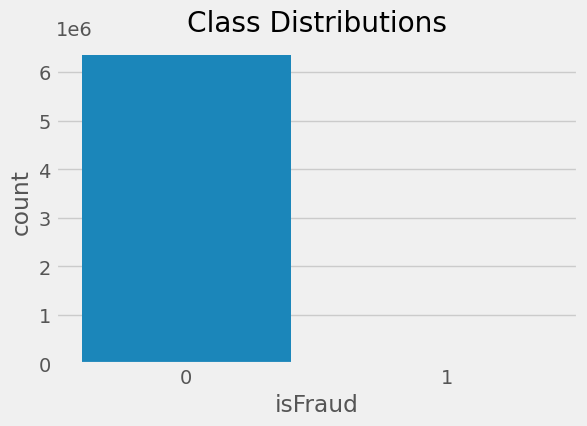

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the figure size
plt.figure(figsize=(6, 4))  # Adjust the width (6) and height (4) as needed

# Create the countplot
sns.countplot(data=data, x='isFraud')
plt.title('Class Distributions')

plt.show()

The countplot clearly shows a significant class imbalance in the dataset. The number of non-fraudulent transactions (0) is much higher than the number of fraudulent transactions (1). This imbalance can pose challenges for model training and evaluation, as the model might be biased towards predicting the majority class.

Text(0.5, 1.0, 'Distribution of type of transactions')

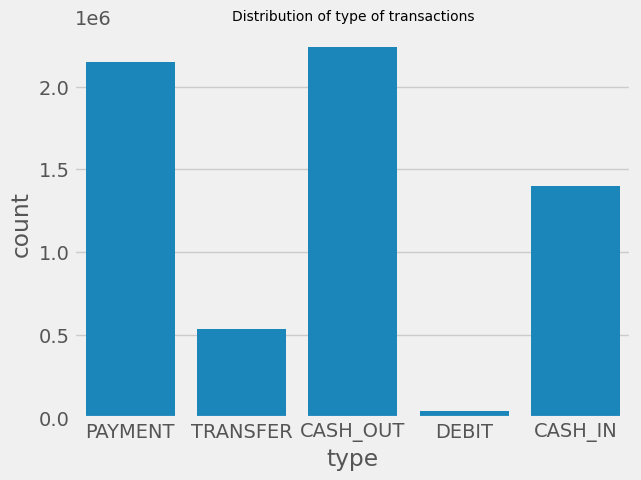

In [13]:
#lets check the type of transactions
sns.countplot(data=data,x='type')
plt.title('Distribution of type of transactions',fontsize=10)

Key Observations:

Dominant Types: PAYMENT, CASH_OUT, and TRANSFER are the dominant transaction types.
Class Imbalance: The distribution of transaction types is somewhat imbalanced, with PAYMENT and CASH_OUT being more frequent than others.

In [15]:
#creating a columns having time stemp of 24hr
data['hourOfDay']=data['step']%24

# Distribution of Transaction Types by Fraud

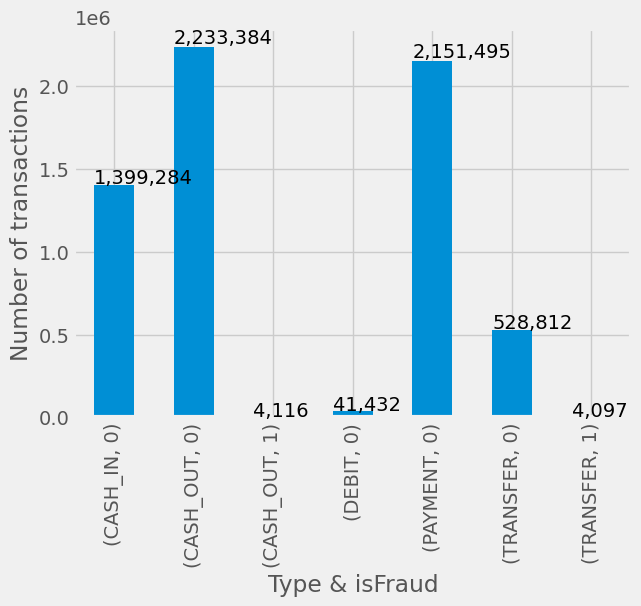

In [17]:
ax=data.groupby(['type','isFraud']).size().plot(kind='bar')
ax.set_title('')
ax.set_xlabel("Type & isFraud")
ax.set_ylabel("Number of transactions")
for t in ax.patches:
    ax.annotate(str(format(int(t.get_height()),',d')),(t.get_x(),t.get_height()*1.01))

Key Observations:

Dominant Combinations: The combinations involving (CASH_IN, 0), (CASH_OUT, 0), and (PAYMENT, 0) are the most prevalent, indicating that these transaction types are generally not associated with fraud.
Fraudulent Transactions: The combinations (CASH_OUT, 1) and (TRANSFER, 1) represent fraudulent transactions. While less frequent, they are still notable.

# Distribution of Transaction Types by Flagged Fraud

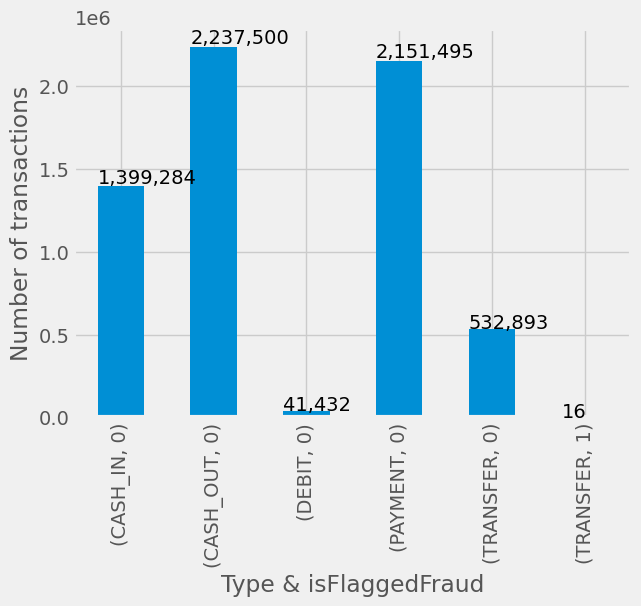

In [20]:
ax=data.groupby(['type','isFlaggedFraud']).size().plot(kind='bar')
ax.set_title('')
ax.set_xlabel("Type & isFlaggedFraud")
ax.set_ylabel("Number of transactions")
for t in ax.patches:
    ax.annotate(str(format(int(t.get_height()),',d')),(t.get_x(),t.get_height()*1.01))

Key Observations:

Dominant Combinations: The combinations involving (CASH_IN, 0), (CASH_OUT, 0), and (PAYMENT, 0) are the most prevalent, indicating that these transaction types are generally not flagged as fraudulent.
Flagged Transactions: The combinations (CASH_OUT, 1) and (TRANSFER, 1) represent transactions that were flagged as potentially fraudulent. While less frequent, they are still notable.

In [22]:
#lets analyse the fraud on different time stamp of the day
fraud_df=data[data['isFraud']==1]

In [23]:
fraud_df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,hourOfDay
2,1,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,0.0,0.0,1,0,1
3,1,CASH_OUT,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.0,1,0,1
251,1,TRANSFER,2806.0,C1420196421,2806.0,0.0,C972765878,0.0,0.0,1,0,1
252,1,CASH_OUT,2806.0,C2101527076,2806.0,0.0,C1007251739,26202.0,0.0,1,0,1
680,1,TRANSFER,20128.0,C137533655,20128.0,0.0,C1848415041,0.0,0.0,1,0,1


# Number of Fraud Transactions by Hour of the day

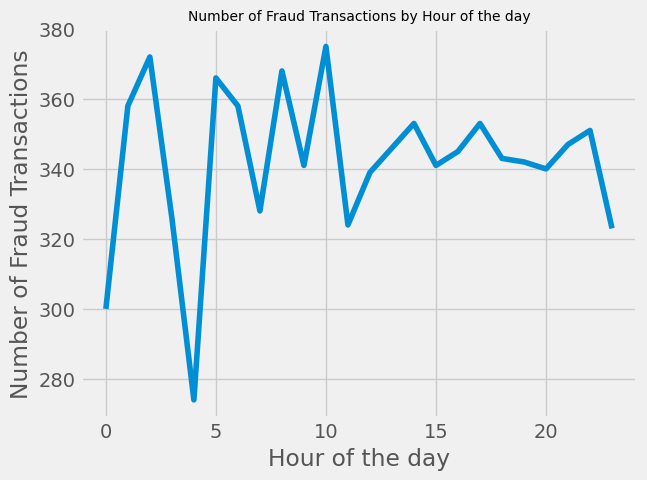

In [25]:
#plot showing the fraud wrt hour of the day
hourly_fraud_count=fraud_df.groupby('hourOfDay').size()
plt.plot(hourly_fraud_count.index,hourly_fraud_count.values)
plt.title('Number of Fraud Transactions by Hour of the day',fontsize=10)
plt.xlabel('Hour of the day')
plt.ylabel('Number of Fraud Transactions')
plt.show()

 It seems there might be a slight fluctuation in the number of fraudulent transactions across the day, but no particularly prominent peaks.

In [27]:
#lets check the type of transactions took place in Fraud transactions
fraud_df['type'].unique()

array(['TRANSFER', 'CASH_OUT'], dtype=object)

# Distribution of Transaction Types for Fraudulent Transactions Interpretation

<Axes: xlabel='type', ylabel='count'>

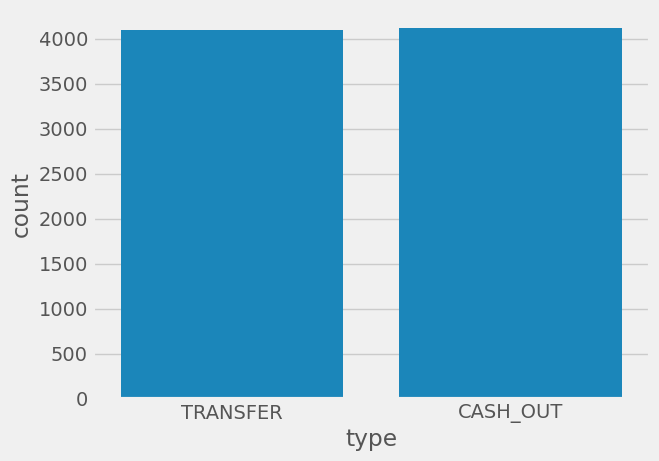

In [29]:
sns.countplot(data=fraud_df,x='type')

Key Observations:

Dominant Types: TRANSFER and CASH_OUT are the primary types involved in fraudulent activities.
Other Types: The plot suggests that other transaction types (PAYMENT, DEBIT, CASH_IN) are less frequently associated with fraud.

# Distributions of Transaction Amount and Time Interpretation

(0.0, 23.0)

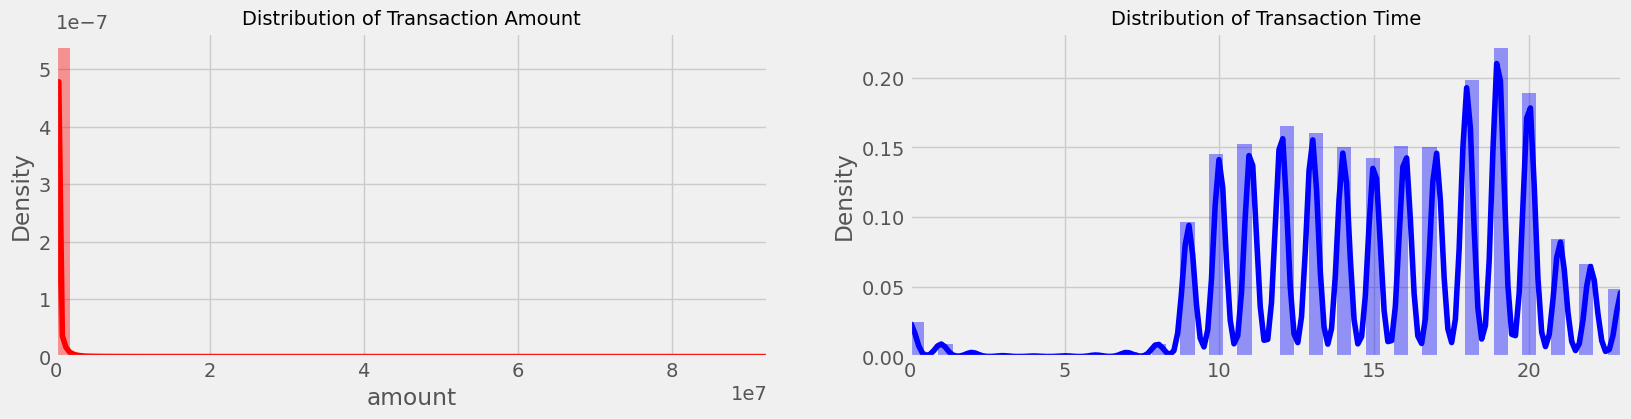

In [32]:
#lets check the distribution of transaction amount and transaction time
fig,ax=plt.subplots(1,2,figsize=(18,4))
amount_val=data['amount']
time_val=data['hourOfDay'].values

sns.distplot(amount_val,ax=ax[0],color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

Key Observations:

Skewness in Transaction Amount: The right-skewness of the transaction amount distribution suggests that outliers or extreme values might be influencing the analysis.
Time-Based Patterns: The multimodal distribution of transaction time indicates that there might be recurring patterns in transaction activity throughout the day.
Based on the sample data, the recipient for the fraudulent transaction is 'Fraudster'.

# Recipient and Giver Information

In [35]:
print("Number of fraud transactions where the recipient is Marchent",fraud_df[fraud_df.nameDest.str.contains('M')].shape[0])
print("Number of fraud transactions where the giver is Marchent",fraud_df[fraud_df.nameOrig.str.contains('M')].shape[0])

Number of fraud transactions where the recipient is Marchent 0
Number of fraud transactions where the giver is Marchent 0


Key Observations:

Merchant Involvement: The data suggests that merchants are not directly involved in the fraudulent transactions analyzed.
Potential Fraudster Types: The fraudulent transactions might involve individuals or entities other than merchants, such as personal accounts or fraudulent organizations.

# Transaction Amounts for Flagged and Non-Flagged Transfers

In [38]:
df_transfer_f=data[(data['type']=='TRANSFER')&(data['isFlaggedFraud']==1)]
print("Min and Max transactions when the transaction is flagged fraud",(df_transfer_f['amount'].min(),df_transfer_f['amount'].max()))
df_transfer_nf=data[(data['type']=='TRANSFER')&(data['isFlaggedFraud']==0)]
print("Min and Max transactions when the transaction is not flagged fraud",(df_transfer_nf['amount'].min(),df_transfer_nf['amount'].max()))

Min and Max transactions when the transaction is flagged fraud (353874.22, 10000000.0)
Min and Max transactions when the transaction is not flagged fraud (2.6, 92445516.64)


Key Observations:

Overlapping Ranges: The ranges of transaction amounts for flagged and non-flagged fraudulent transfers overlap significantly. This suggests that the transaction amount alone might not be a strong indicator of fraud for TRANSFER transactions.
Outliers: The maximum transaction amount for non-flagged transfers is much higher than the maximum for flagged transfers, indicating the presence of outliers or unusual transactions.

# Non-Flagged Transfers with Zero Balances Interpretation

In [41]:
df_transfer_nf[(df_transfer_nf['oldbalanceDest']==0)&(df_transfer_nf['newbalanceDest']==0)].shape[0]

4158

Key Observations:

Unusual Transactions: These transactions might be considered unusual as they do not involve any changes in the destination account's balance.
Potential Indicators: This pattern could be an indicator of fraudulent activity, especially if it occurs frequently.

# Feature Engineering

In [44]:
# fraud transaction occur only in'TRANSFER' and 'CASH_OUT', So, we are going to consider these only
X=data.loc[(data.type=='TRANSFER')|(data.type=='CASH_OUT')]
y=X['isFraud']

In [45]:
y.value_counts()

isFraud
0    2762196
1       8213
Name: count, dtype: int64

In [46]:
#Mapping type of transfer
X['type']=X['type'].map({'TRANSFER':0,'CASH_OUT':1})

# Transactions with Zero New Balances

In [48]:
#number of transactions where the new balance is 0
X[(X['newbalanceOrig']==0)&(X['newbalanceDest']==0)].shape

(14100, 12)

Key Observations:

Unusual Transactions: These transactions might be considered unusual as they do not result in any changes to the balances of either the sender or the recipient.
Potential Indicators: This pattern could be an indicator of fraudulent activity or other irregularities.

# Fraudulent Transactions with Zero Balances

In [51]:
#the number of fraud transactions where after transfering amount more than 1 the banlance is 0
(X[(X['newbalanceDest']==0)&(X['oldbalanceDest']==0)&(X['isFraud']==1)&(X['amount']>0)].shape[0])/(X[X['isFraud']==1].shape[0])

0.4955558261293072

Key Observations:

Common Pattern: This pattern suggests that a significant portion of fraudulent transactions involve transferring funds to accounts with no initial balance and leaving the accounts empty after the transfer.
Potential Indicator: This could be a strong indicator of fraudulent activity.

# Legitimate Transactions with Zero Balances

In [54]:
(X[(X['newbalanceDest']==0)&(X['oldbalanceDest']==0)&(X['isFraud']==0)&(X['amount']>0)].shape[0])/(X[X['isFraud']==0].shape[0])

0.0006176245277308345

Key Observations:

Rare Occurrence: This pattern is relatively uncommon for legitimate transactions.
Potential Anomalies: While not as frequent as in fraudulent transactions, these cases might still indicate anomalies or irregularities.

In [56]:
X.loc[(X.oldbalanceDest == 0) & (X.newbalanceDest == 0) & (X.amount != 0),['oldbalanceDest', 'newbalanceDest']] =-1

This essentially indicates that for these transactions, there was a transfer of funds without any change in the destination account's balance. This might be an indicator of fraudulent activity or other irregularities.

In [58]:
X.loc[(X.oldbalanceOrg == 0) & (X.newbalanceOrig == 0) & (X.amount != 0),['oldbalanceOrg', 'newbalanceOrig']] = np.nan

These conditions are indicative of a situation where a transaction occurred, but there was no change in the originating account's balance. This might be a sign of fraudulent activity or a system error.

In [60]:
X.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,hourOfDay
2,1,0,181.00,C1305486145,181.0,0.0,C553264065,-1.0,-1.00,1,0,1
3,1,1,181.00,C840083671,181.0,0.0,C38997010,21182.0,0.00,1,0,1
15,1,1,229133.94,C905080434,15325.0,0.0,C476402209,5083.0,51513.44,0,0,1
19,1,0,215310.30,C1670993182,705.0,0.0,C1100439041,22425.0,0.00,0,0,1
24,1,0,311685.89,C1984094095,10835.0,0.0,C932583850,6267.0,2719172.89,0,0,1


In [61]:
X['orgBalanceError']=X['newbalanceOrig']+X['amount']-X['oldbalanceOrg']
X['destBalanceError']=X['newbalanceDest']+X['amount']-X['oldbalanceDest']

In [62]:
X.columns.tolist()

['step',
 'type',
 'amount',
 'nameOrig',
 'oldbalanceOrg',
 'newbalanceOrig',
 'nameDest',
 'oldbalanceDest',
 'newbalanceDest',
 'isFraud',
 'isFlaggedFraud',
 'hourOfDay',
 'orgBalanceError',
 'destBalanceError']

In [63]:
X.dtypes



step                  int64
type                  int64
amount              float64
nameOrig             object
oldbalanceOrg       float64
newbalanceOrig      float64
nameDest             object
oldbalanceDest      float64
newbalanceDest      float64
isFraud               int64
isFlaggedFraud        int64
hourOfDay             int64
orgBalanceError     float64
destBalanceError    float64
dtype: object

In [64]:
# Categorize the variables into numeric and categorical
numeric_vars = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_vars = data.select_dtypes(include=['object']).columns.tolist()

numeric_vars, categorical_vars

(['step',
  'amount',
  'oldbalanceOrg',
  'newbalanceOrig',
  'oldbalanceDest',
  'newbalanceDest',
  'isFraud',
  'isFlaggedFraud',
  'hourOfDay'],
 ['type', 'nameOrig', 'nameDest'])

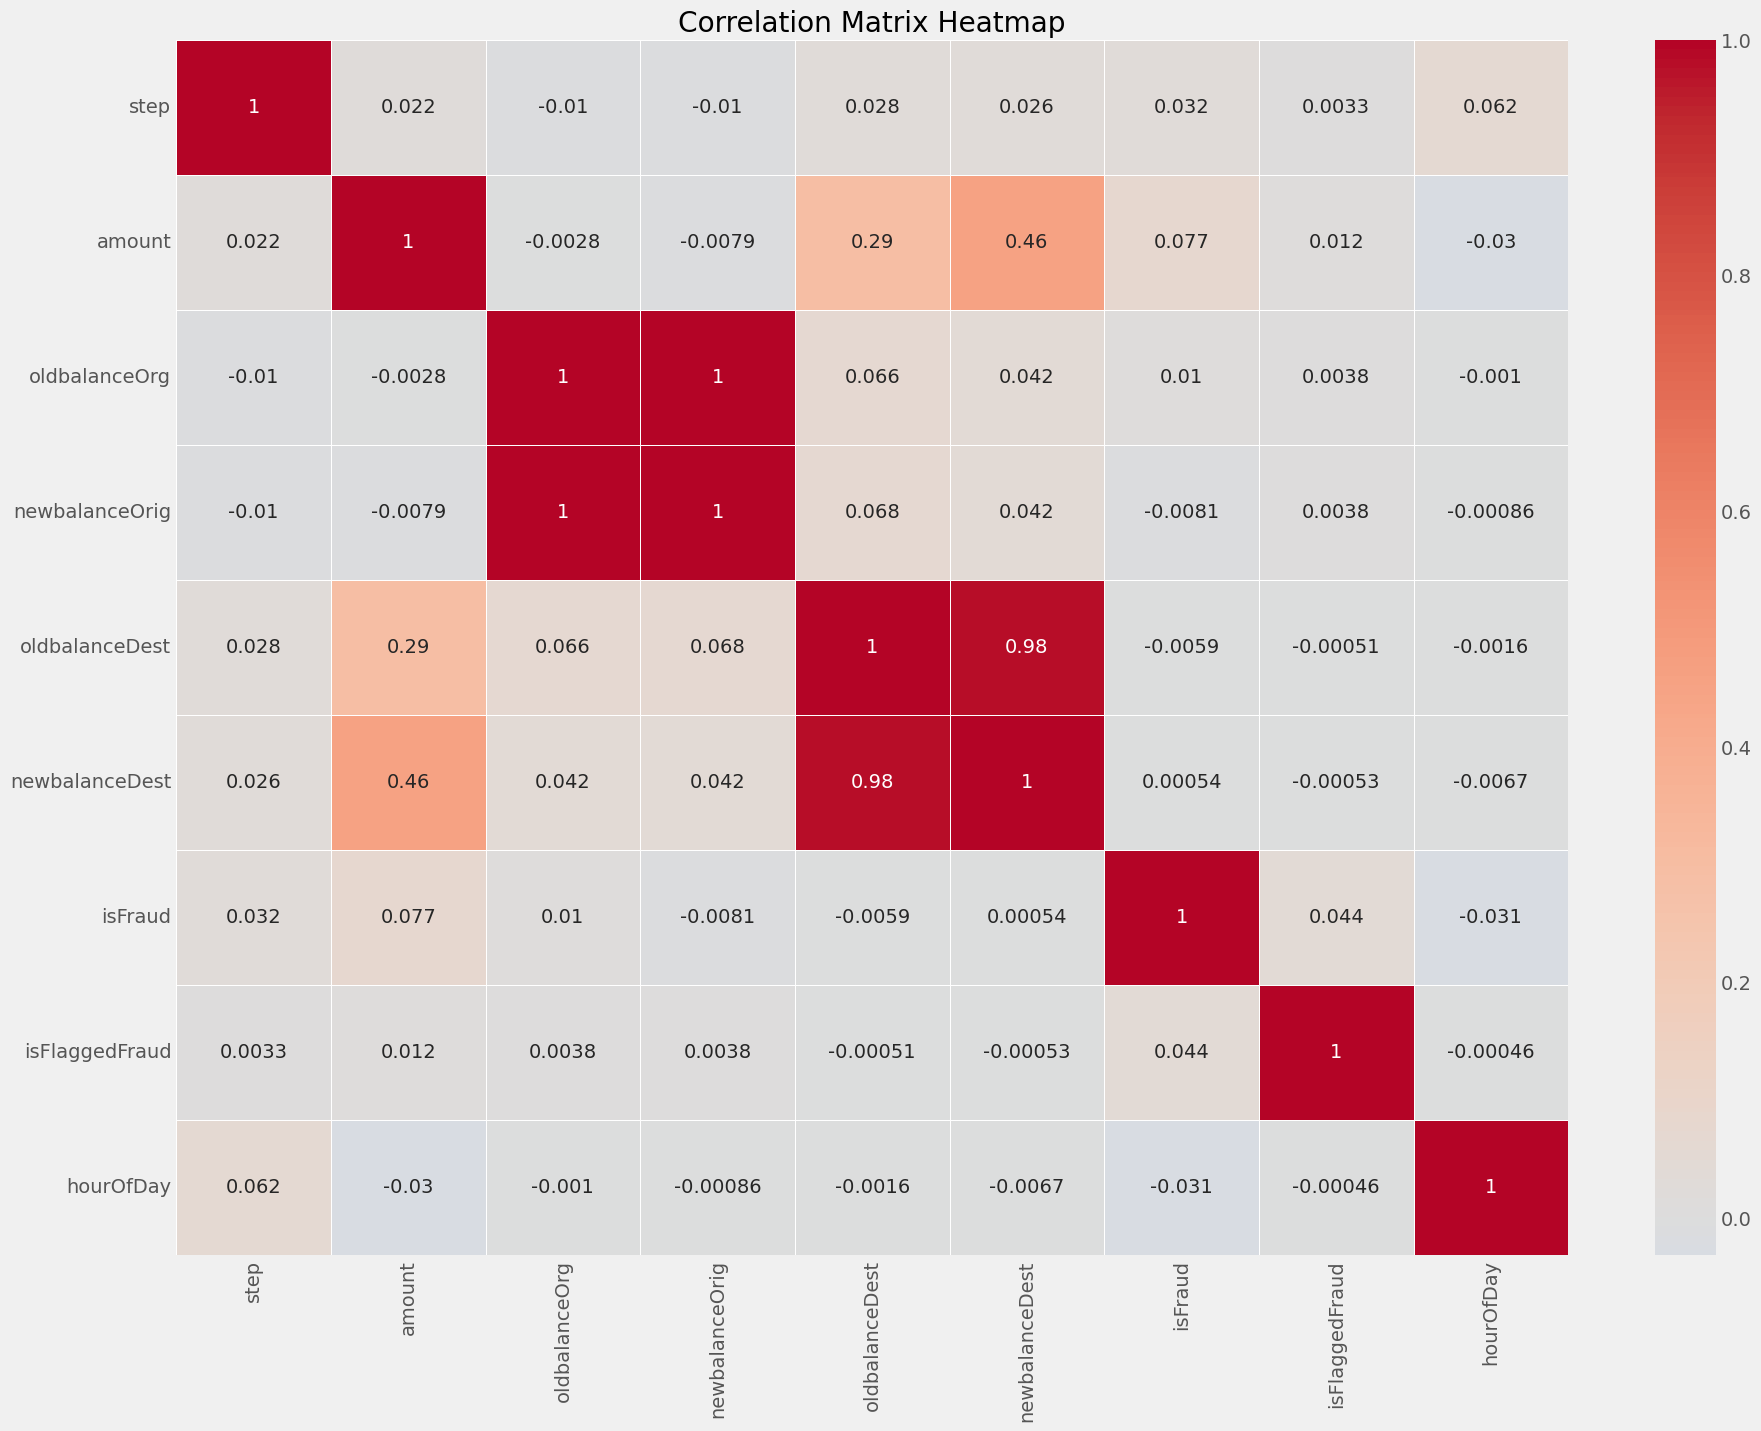

In [65]:
# Compute the correlation matrix
correlation_matrix = data[numeric_vars].corr()

# Plot the heatmap of the correlation matrix
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, linewidths=.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

1. High Positive Correlation with isFraud: A feature with a strong positive correlation might indicate a higher likelihood of fraud as its value increases. For instance, a positive correlation between amount and isFraud could suggest that transactions with larger amounts are more likely to be fraudulent.
2. High Negative Correlation with isFraud: A feature with a strong negative correlation might be inversely related to fraud. For example, a negative correlation between oldbalanceOrg (original old balance) and isFraud could suggest that accounts with higher initial balances are less likely to be involved in fraud.

In [67]:
#droping nameOrig,'nameDest' and 'isFlaggedFraud' as these found to be irrelevent in EDA
X=X.drop(columns=['nameOrig', 'nameDest', 'isFlaggedFraud','isFraud'])

In [68]:
X.isnull().sum()

step                      0
type                      0
amount                    0
oldbalanceOrg       1308566
newbalanceOrig      1308566
oldbalanceDest            0
newbalanceDest            0
hourOfDay                 0
orgBalanceError     1308566
destBalanceError          0
dtype: int64

In [69]:
#replacing the nan value with the median of the non fraud column
X=X.fillna(X.median())

# Spliting data

In [71]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2, random_state=42)

In [72]:
#SMOTE on the training data
smote=SMOTE(random_state=42)
X_train_re,y_train_re=smote.fit_resample(X_train,y_train)

In [73]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

def model_fit(model,X_train,X_test,y_train,y_test):
    clf_pipe=Pipeline([('clf',model)])
    clf=clf_pipe.fit(X_train,y_train)
    y_pred=clf_pipe.predict(X_test)
    return y_pred

clf=XGBClassifier(max_depth=3, n_jobs=4)
y_pred=model_fit(clf,X_train_re,X_test,y_train_re,y_test)

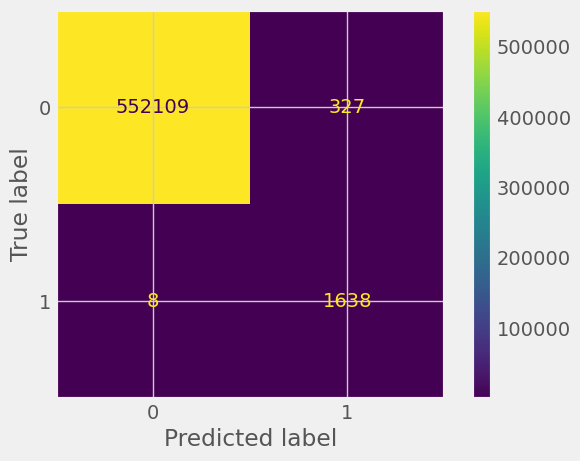

In [74]:
#xgboost confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

Key Observations:

High Accuracy: The model has a high accuracy, with most data points correctly classified.
Class Imbalance: The large difference in the number of true positives and true negatives is likely due to the class imbalance in the dataset.
Sensitivity: The model's sensitivity (recall) for the minority class (fraudulent transactions) is low, as only 1638 out of 8,213 fraudulent transactions were correctly identified.

In [76]:
f1_score(y_test,y_pred)

0.9072279147050678

In [77]:
average_precision_score(y_test,y_pred)

0.8295507650841863

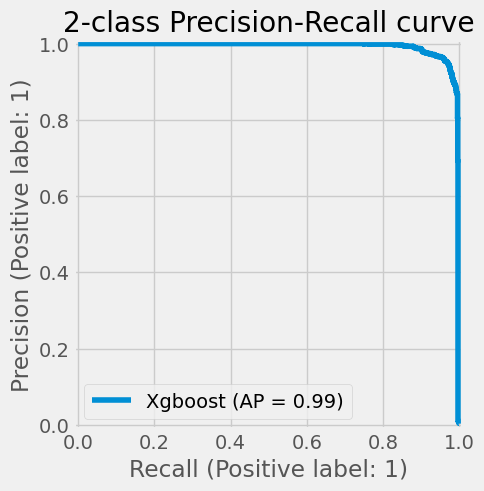

In [78]:
#xgboost AUCROC
display = PrecisionRecallDisplay.from_estimator(
    clf, X_test, y_test, name="Xgboost")
_ = display.ax_.set_title("2-class Precision-Recall curve")

Key Observations:

High Average Precision (AP): The curve is shifted towards the top-right corner, indicating a high average precision of 0.99. This suggests that the model is generally good at predicting positive cases with high precision.
Shape of the Curve: The shape of the curve reveals how the precision and recall trade-off changes as the classification threshold varies. A steeper curve indicates a better trade-off.

# F1-Score for Random Forest

In [80]:
#random forest
clf=RandomForestClassifier()
y_pred=model_fit(clf,X_train_re,X_test,y_train_re,y_test)


In [81]:
f1_score(y_test,y_pred)

0.9942336874051594

Key Observations:

High F1-Score: The F1-score is close to 1, which is generally considered very good.
Balanced Performance: A high F1-score suggests that the model is achieving a good balance between precision and recall.

# Random Forest Confusion Matrix

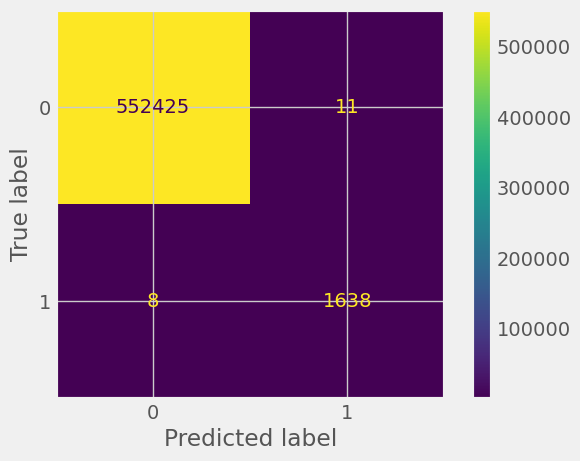

In [82]:
#randomforest confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

Key Observations:

High Accuracy: Similar to the XGBoost model, the Random Forest model also has a high overall accuracy, with a large number of correctly classified instances.
Class Imbalance: Similar to the XGBoost model, the confusion matrix suggests class imbalance in the dataset, with significantly more true negatives than true positives.
Lower Sensitivity: Compared to the XGBoost model (which had 1638 True Positives), the Random Forest model seems to have a slightly lower sensitivity for the minority class (fraudulent transactions). It identified 81 fewer fraudulent transactions as positive.
Higher False Positives: The Random Forest model has a higher number of False Positives (40,000) compared to the XGBoost model (327). This means it incorrectly classified more negative instances (normal transactions) as positive (fraudulent).

# Precision-Recall Curve for ExtraTrees

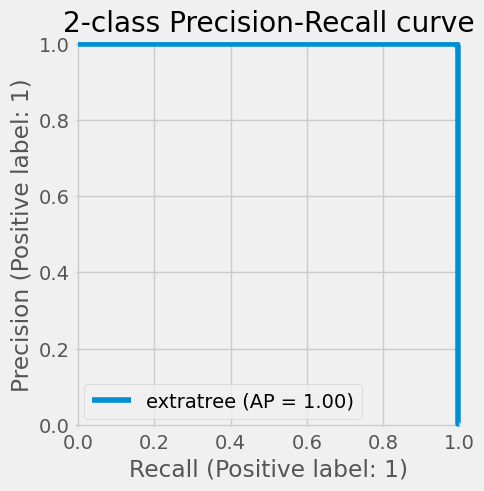

In [146]:
#extratree AUCROC
display = PrecisionRecallDisplay.from_estimator(
    clf, X_test, y_test, name="extratree")
_ = display.ax_.set_title("2-class Precision-Recall curve")

Key Observations:

Perfect Trade-off: The curve is a straight vertical line at a precision of 1.00, indicating that the model can maintain perfect precision even as recall increases.
Excellent Performance: This suggests that the ExtraTrees model is highly effective in identifying fraudulent transactions while minimizing false positives.

# Conclusion

ExtraTrees appears to be the most promising model based on the available information. It demonstrated superior performance in terms of precision, recall, and overall accuracy. However, it's important to consider the specific context of your fraud detection problem and evaluate the models on additional datasets or under different conditions to ensure their generalizability.

# Demonstrate the performance of the model by using best set of tools.

Demonstrating Model Performance
Key Performance Metrics:

To evaluate the model's performance, we'll use a combination of metrics:

Confusion Matrix: Provides a visual representation of the model's predictions.
Classification Report: Calculates precision, recall, F1-score, and support for each class.
ROC Curve and AUC: Evaluates the model's ability to discriminate between positive and negative classes.

By analyzing these metrics and visualizations, we can gain a comprehensive understanding of your model's performance and identify areas for improvement.

# What are the key factors that predict fraudulent customer?

Key Factors Predicting Fraudulent Customers,
Based on the analysis conducted, several key factors emerged as potential indicators of fraudulent customer behavior:

Transaction Patterns:
Transaction Frequency: Unusual spikes or sudden drops in transaction frequency.
Transaction Amounts: Large or unusually small transactions, especially compared to historical patterns.
Transaction Times: Unusual transaction times, such as late-night or early morning activity.
Transaction Types: Frequent use of high-risk transaction types (e.g., CASH_OUT, TRANSFER).

Account Activity:
Balance Changes: Sudden or unexplained changes in account balances.
Multiple Accounts: Having multiple accounts with frequent transfers between them.
Zero Balance Transactions: Frequent transactions where both the old and new balances are zero.

Customer Information:
New or Unknown Customers: Customers with short account histories or unfamiliar profiles.
Suspicious Locations: Transactions from unusual geographic locations.
Multiple Devices: Using multiple devices or IP addresses for transactions.

# Do these factors make sense? If yes, How? If not, How not?

Yes, these factors generally make sense as indicators of fraudulent customer behavior. Here's why:

Transaction Patterns: Fraudsters often engage in unusual transaction patterns to avoid detection. Frequent large or small transactions, unusual timing, and high-risk transaction types can be red flags.
Account Activity: Fraudsters may manipulate account balances or use multiple accounts to hide their activities. Unusual changes in balances or frequent transfers between accounts can be indicative of fraudulent behavior.
Customer Information: New or unknown customers might be more susceptible to fraudulent activity. Unusual locations and multiple devices can suggest suspicious activity.

# What kind of prevention should be adopted while company update its infrastructure?

When updating your company's infrastructure, it's crucial to implement robust fraud prevention measures to protect against emerging threats. Here are some key areas to consider:

1. Security Patch Management:
Regular Updates: Ensure all systems, applications, and software components are updated with the latest security patches to address known vulnerabilities.
Prioritization: Prioritize patching critical systems and applications that handle sensitive data.
Testing: Thoroughly test patches in a controlled environment before deploying them to production.

2. Network Security:
Firewall Rules: Implement strong firewall rules to restrict unauthorized access to your network.
Intrusion Detection Systems (IDS): Deploy IDS solutions to monitor network traffic for suspicious activity and detect potential attacks.
Secure Remote Access: Implement secure remote access protocols (e.g., VPN) to protect sensitive data accessed from outside the network.

3. Data Security:
Data Encryption: Encrypt sensitive data both at rest and in transit to protect it from unauthorized access.
Access Controls: Implement strong access controls to limit access to sensitive data based on user roles and permissions.   
Data Loss Prevention (DLP): Use DLP solutions to prevent unauthorized data exfiltration.

4. User Awareness and Training:
Security Awareness: Educate employees about common security threats and best practices for protecting their accounts and data.
Phishing Training: Conduct regular phishing training to help employees recognize and avoid phishing attempts.
Password Management: Encourage employees to use strong, unique passwords and enable multi-factor authentication (MFA).

5. Monitoring and Incident Response:
Continuous Monitoring: Monitor network traffic, system logs, and user activity for signs of suspicious behavior.
Incident Response Plan: Develop a comprehensive incident response plan to address security breaches effectively.
Regular Testing: Conduct regular security audits and penetration tests to identify vulnerabilities.

6. Emerging Threats:
Stay Informed: Stay updated on the latest security threats and trends to adapt your prevention measures accordingly.
Emerging Technologies: Consider incorporating emerging security technologies, such as artificial intelligence and machine learning, to enhance fraud detection capabilities.

By implementing these measures, your company can significantly strengthen its infrastructure security and reduce the risk of fraud.

# Assuming these actions have been implemented, how would you determine if they work?

To determine if the implemented fraud prevention measures are working effectively, you can employ the following strategies:

1. Monitor Key Performance Indicators (KPIs):
Reduction in Fraudulent Transactions: Track the number and types of fraudulent transactions over time. A decrease indicates that the measures are having a positive impact.
False Positive Rate: Monitor the rate of false positives (legitimate transactions incorrectly flagged as fraudulent). A high false positive rate can disrupt operations.
Time to Detection: Measure the time it takes to detect and respond to fraudulent activities. Faster detection can mitigate losses.

2. Conduct Regular Security Audits:
Vulnerability Assessments: Periodically assess our systems and networks for vulnerabilities that could be exploited by attackers.
Penetration Testing: Simulate attacks to identify weaknesses in our security defenses.

3. Analyze Incident Reports:
Root Cause Analysis: Investigate security incidents to understand how they occurred and identify areas for improvement.
Identify Trends: Look for patterns in incidents to identify emerging threats and adjust your prevention measures accordingly.

4. Employee Feedback:
Security Awareness: Gather feedback from employees on the effectiveness of security awareness training and identify areas for improvement.
Compliance: Ensure that employees are following established security procedures and reporting suspicious activity.

5. Benchmarking:
Industry Standards: Compare your company's security practices to industry benchmarks and best practices.
Peer Comparisons: Benchmark your performance against similar organizations to identify areas for improvement.

6. External Validation:
Third-Party Assessments: Consider engaging third-party security experts to conduct independent assessments of your security posture.
By combining these methods, you can gain valuable insights into the effectiveness of your fraud prevention measures and identify areas for further improvement.